In [19]:
import requests, io
from io import BytesIO
import sys
import time

import datasets
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import psutil


sys.path.append("../src/")

import dsperf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# benchmarking various approaches to process image datasets
Questions we are trying to address:
* how much RAM usage / time does it take depending on which pre-processing step is done at preparation time vs query time
    1. pre-process: load and tokenize, query time: read only
    2. pre-process: load images, query time: tokenize and read
    3. pre-process: none, query time: load images and tokenize (this can be achived using the `.with_transform` dataset method)
* impact of local vs remote urls (IO bound)
* dataset mapping vs query time transformations

## Setup
### Data preparation
* save locally a product image from nike.com
* load processor

In [2]:
IMAGE_URL = "https://static.nike.com/a/images/t_default/b23b37f4-1278-4719-8290-4c673d3ef1e0/sportswear-womens-fleece-sweatshirt-vgstZS.png"
LOCAL_IMAGE_PATH = "../data/image_example.jpg"

DEFAULT_SIZE = 1000


img = Image.open(BytesIO(requests.get(IMAGE_URL).content)).convert('RGB').resize((300,300))
img.save(LOCAL_IMAGE_PATH)

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

### Setting up the test procedure

In [3]:
test_results = {}

N_INFERENCES = 100

def init_dataset(path: str, size: int = DEFAULT_SIZE) -> datasets.Dataset:
    data = {
        "filepath": [path for _ in range(size)], 
        "label": ["cat" for _ in range(size)],
        }

    return datasets.Dataset.from_dict(data)

dataset = init_dataset(path=LOCAL_IMAGE_PATH)

test = dsperf.performance.TestProcedure()

test.start_preprocessing()
time.sleep(.5) # add here the pre-processing steps
test.stop_preprocessing()

test.test_query_performance(dataset, 
    field_to_extract="filepath", 
    n_inferences=10000)

_ = test.get_record()

starting transformation:
PerfCheck(status=COMPLETED, cpu_perf=0.50 sec, memory=0.00MB)

querying 10000 batches of size 16 the dataset


100%|██████████| 10000/10000 [00:00<00:00, 91391.12it/s]

PerfCheck(status=COMPLETED, cpu_perf=0.12 sec, memory=0.25MB)


### Defining the different preproc functions
* we need functions to load images (either locally or remotely from a url)
* we need functions to tokenize the images
* we will also build functions that combine both in order to evaluate the benefits of doing the transformations in a single pass

In [4]:
def stream_image_from_url(url: str):
    return BytesIO(requests.get(url).content)


def is_url(path: str):
    return path.startswith("http")


def reformat_path(path: str):
    if is_url(path):
        return stream_image_from_url(path)
    return path


def get_image(path: str):
    return (
        Image.open(reformat_path(path))
        .convert('RGB')
        .resize((300,300)))


def load_images(examples):
    return {"pixel_values": [get_image(filepath) for filepath in examples["filepath"]]}


def encode(examples):
    return processor(images=examples["pixel_values"], return_tensors="pt", padding=True)


def single_pass(examples):
    imgs = [get_image(filepath) for filepath in examples["filepath"]]
    return processor(images=imgs, return_tensors="pt", padding=True)


def _transform(examples):
    """note: with_transform requires to define all"""
    imgs = [get_image(filepath) for filepath in examples["filepath"]]
    examples.update(processor(images=imgs, return_tensors='pt'))
    examples.pop('filepath')
    return examples

## local path, multi steps, all preproc

In [5]:
dataset = init_dataset(LOCAL_IMAGE_PATH)

test = dsperf.performance.TestProcedure()

test.start_preprocessing()
dataset = dataset.map(load_images, remove_columns=["filepath"], batched=True, batch_size=32)
dataset = dataset.map(encode, remove_columns=["pixel_values"], batched=True, batch_size=32)
test.stop_preprocessing()

test.test_query_performance(dataset, 
    field_to_extract="pixel_values", 
    n_inferences=N_INFERENCES)

test_results["local_all_preproc"] = test.get_record()


starting transformation:


100%|██████████| 32/32 [00:07<00:00,  4.42ba/s]


PerfCheck(status=COMPLETED, cpu_perf=27.60 sec, memory=837.81MB)

querying 100 batches of size 16 the dataset


100%|██████████| 100/100 [00:43<00:00,  2.32it/s]

PerfCheck(status=COMPLETED, cpu_perf=43.09 sec, memory=245.89MB)


## remote url, multi steps, all preproc

In [6]:
dataset = init_dataset(IMAGE_URL)

# open images and save to dataset
test = dsperf.performance.TestProcedure()

test.start_preprocessing()
dataset = dataset.map(load_images, remove_columns=["filepath"], batched=True, batch_size=32)
dataset = dataset.map(encode, remove_columns=["pixel_values"], batched=True, batch_size=32)
test.stop_preprocessing()

test.test_query_performance(dataset, 
    field_to_extract="pixel_values", 
    n_inferences=N_INFERENCES)

test_results["url_all_preproc"] = test.get_record()

starting transformation:


100%|██████████| 32/32 [00:07<00:00,  4.51ba/s]


PerfCheck(status=COMPLETED, cpu_perf=141.57 sec, memory=636.75MB)

querying 100 batches of size 16 the dataset


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]

PerfCheck(status=COMPLETED, cpu_perf=43.25 sec, memory=118.00MB)


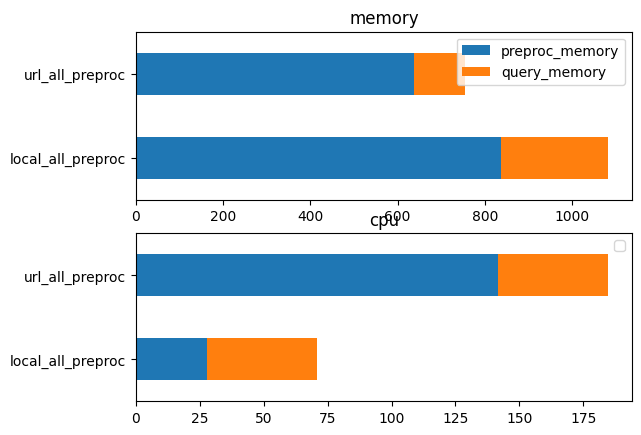

In [7]:
_ = dsperf.plot.plot_test_results(test_results)

## single pass preproc

starting transformation:


100%|██████████| 32/32 [00:03<00:00,  8.04ba/s]


PerfCheck(status=COMPLETED, cpu_perf=4.01 sec, memory=552.45MB)

querying 100 batches of size 16 the dataset


100%|██████████| 100/100 [00:44<00:00,  2.24it/s]

PerfCheck(status=COMPLETED, cpu_perf=44.64 sec, memory=-490.69MB)


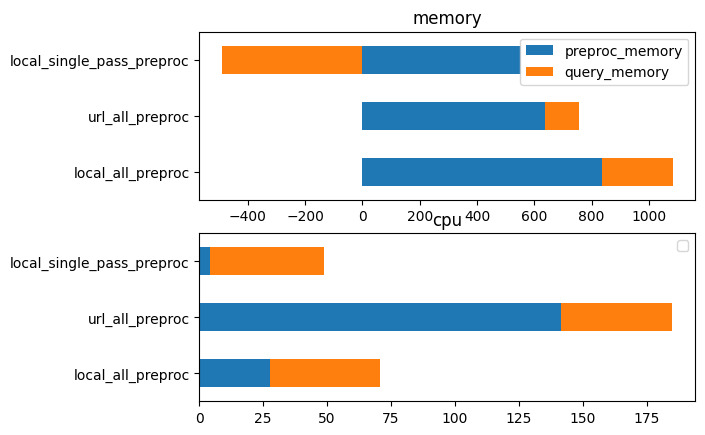

In [8]:
dataset = init_dataset(LOCAL_IMAGE_PATH)

test = dsperf.performance.TestProcedure()

test.start_preprocessing()
dataset = dataset.map(_transform, remove_columns=["filepath"], batched=True, batch_size=32)
test.stop_preprocessing()

test.test_query_performance(dataset, 
    field_to_extract="pixel_values", 
    n_inferences=N_INFERENCES)

test_results["local_single_pass_preproc"] = test.get_record()
_ = dsperf.plot.plot_test_results(test_results)

## using with_transform instead
`with_transform` operates the requested transformation only on the fly

starting transformation:
PerfCheck(status=COMPLETED, cpu_perf=0.02 sec, memory=2.53MB)

querying 100 batches of size 16 the dataset


100%|██████████| 100/100 [00:04<00:00, 24.30it/s]

PerfCheck(status=COMPLETED, cpu_perf=4.12 sec, memory=117.03MB)


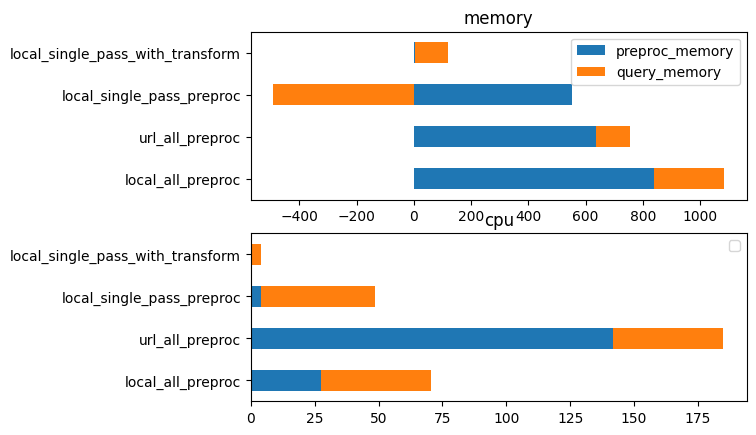

In [9]:
dataset = init_dataset(LOCAL_IMAGE_PATH)

test = dsperf.performance.TestProcedure()

test.start_preprocessing()
dataset = dataset.with_transform(_transform)
test.stop_preprocessing()

test.test_query_performance(dataset, 
    field_to_extract="pixel_values", 
    n_inferences=N_INFERENCES)

test_results["local_single_pass_with_transform"] = test.get_record()
_ = dsperf.plot.plot_test_results(test_results)

## Trying some Memory optimization
avoid to store images into `imgs` variable.

starting transformation:
PerfCheck(status=COMPLETED, cpu_perf=0.02 sec, memory=0.12MB)

querying 100 batches of size 16 the dataset


100%|██████████| 100/100 [00:04<00:00, 24.33it/s]


PerfCheck(status=COMPLETED, cpu_perf=4.11 sec, memory=14.55MB)


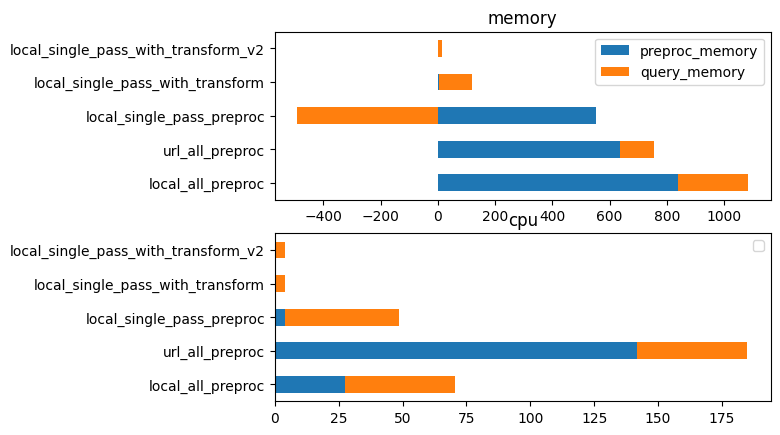

In [10]:
def _transform_v2(examples):
    """note: with_transform requires to define all"""
    examples.update(processor(
        images=[get_image(filepath) for filepath in examples["filepath"]], 
        return_tensors='pt'))
    examples.pop('filepath')
    return examples

dataset = init_dataset(LOCAL_IMAGE_PATH)

test = dsperf.performance.TestProcedure()

test.start_preprocessing()
dataset = dataset.with_transform(_transform_v2)
test.stop_preprocessing()

test.test_query_performance(dataset, 
    field_to_extract="pixel_values", 
    n_inferences=N_INFERENCES)

test_results["local_single_pass_with_transform_v2"] = test.get_record()
_ = dsperf.plot.plot_test_results(test_results)

In [11]:
# not much value into this "optimization"
_ = test_results.pop("local_single_pass_with_transform_v2")

## with_transform with url

starting transformation:
PerfCheck(status=COMPLETED, cpu_perf=0.02 sec, memory=0.06MB)

querying 100 batches of size 16 the dataset


100%|██████████| 100/100 [03:05<00:00,  1.85s/it]

PerfCheck(status=COMPLETED, cpu_perf=185.49 sec, memory=3.38MB)


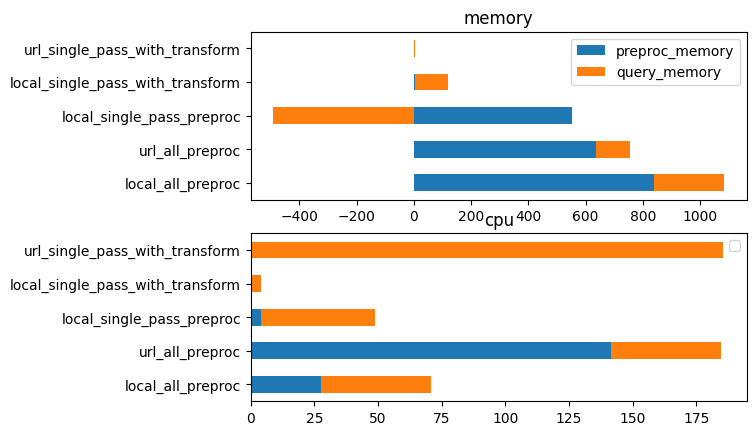

In [12]:
dataset = init_dataset(IMAGE_URL)

test = dsperf.performance.TestProcedure()

test.start_preprocessing()
dataset = dataset.with_transform(_transform)
test.stop_preprocessing()

test.test_query_performance(dataset, 
    field_to_extract="pixel_values", 
    n_inferences=N_INFERENCES)

test_results["url_single_pass_with_transform"] = test.get_record()

fig = dsperf.plot.plot_test_results(test_results)

In [20]:
fig.savefig("../figures/performance_plots_2.jpg")

pd.DataFrame(test_results).to_csv("../data/outputs/test_results.csv")

### Conclusions
* relying on remote urls (IO bound) is the most detrimental and should be avoided when possible
* `.with_transform` seems to provide strong benefit over `.map` on both pre-proc time and query time when working on local data.